In [1]:
print("hello world")

hello world


In [2]:
import torch

In [3]:
!pip install torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.9/101.9 MB 5.5 MB/s  0:00:18m0:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [torch]32m1/2 [torch]


In [10]:
import torch

In [3]:
torch.cuda.is_available()

True

In [4]:
torch.mps.is_available()

False

# Regression Regularization Visualization: L1, L2, and ElasticNet

This notebook creates an educational video demonstrating the differences between L1 (Lasso), L2 (Ridge), and ElasticNet regularization in regression models.

## Learning Objectives:
- Understand how different regularization techniques affect model coefficients
- Visualize the trade-off between bias and variance
- See how regularization helps prevent overfitting
- Compare coefficient shrinkage patterns across different methods


In [29]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.patches import Rectangle
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
from IPython.display import HTML, display
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")
print(f"NumPy version: {np.__version__}")
print(f"Matplotlib version: {plt.matplotlib.__version__}")


Libraries imported successfully!
NumPy version: 2.2.6
Matplotlib version: 3.10.6


In [30]:
# Generate synthetic dataset with controlled characteristics
np.random.seed(42)

# Dataset parameters
n_samples = 200
n_features = 10
n_informative = 5  # Only 5 features are actually informative
noise_level = 0.1

# Generate feature matrix
X = np.random.randn(n_samples, n_features)

# Create true coefficients (sparse - only first 5 features matter)
true_coef = np.zeros(n_features)
true_coef[:n_informative] = np.random.randn(n_informative) * 2
true_coef[0] = 3.0  # Make first feature very important
true_coef[1] = -2.5  # Make second feature important with negative effect

# Generate target variable
y = X @ true_coef + np.random.randn(n_samples) * noise_level

# Add some outliers to make the problem more challenging
outlier_indices = np.random.choice(n_samples, size=10, replace=False)
y[outlier_indices] += np.random.randn(10) * 2

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Dataset created:")
print(f"- Training samples: {X_train.shape[0]}")
print(f"- Test samples: {X_test.shape[0]}")
print(f"- Features: {n_features}")
print(f"- Informative features: {n_informative}")
print(f"- True coefficients: {true_coef}")
print(f"- Noise level: {noise_level}")


Dataset created:
- Training samples: 140
- Test samples: 60
- Features: 10
- Informative features: 5
- True coefficients: [ 3.         -2.5        -1.58483984 -0.61592306 -3.78722933  0.
  0.          0.          0.          0.        ]
- Noise level: 0.1


In [31]:
# Create coefficient path visualization function
def plot_coefficient_paths(alphas, coef_paths, model_names, true_coef=None):
    """
    Plot coefficient paths for different regularization methods
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Regularization Comparison: Coefficient Paths', fontsize=16, fontweight='bold')
    
    # Plot 1: All coefficient paths
    ax1 = axes[0, 0]
    for i, (coef_path, name) in enumerate(zip(coef_paths, model_names)):
        # Plot each feature's coefficient path
        for j in range(coef_path.shape[1]):
            ax1.plot(alphas, coef_path[:, j], alpha=0.7, linewidth=1, 
                    label=name if j == 0 else "")
    
    if true_coef is not None:
        ax1.axhline(y=0, color='black', linestyle='--', alpha=0.3)
        for i, true_val in enumerate(true_coef):
            if abs(true_val) > 0.1:  # Only show lines for significant true coefficients
                ax1.axhline(y=true_val, color='red', linestyle=':', alpha=0.5, 
                           label='True' if i == 0 else "")
    
    ax1.set_xlabel('Regularization Strength (α)')
    ax1.set_ylabel('Coefficient Value')
    ax1.set_title('Coefficient Paths: All Features')
    ax1.set_xscale('log')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: L1 (Lasso) - shows sparsity
    ax2 = axes[0, 1]
    l1_coef = coef_paths[0]  # Assuming L1 is first
    for j in range(l1_coef.shape[1]):
        ax2.plot(alphas, l1_coef[:, j], 'b-', alpha=0.7, linewidth=2)
    ax2.set_xlabel('Regularization Strength (α)')
    ax2.set_ylabel('Coefficient Value')
    ax2.set_title('L1 Regularization (Lasso) - Feature Selection')
    ax2.set_xscale('log')
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: L2 (Ridge) - shows shrinkage
    ax3 = axes[1, 0]
    l2_coef = coef_paths[1]  # Assuming L2 is second
    for j in range(l2_coef.shape[1]):
        ax3.plot(alphas, l2_coef[:, j], 'g-', alpha=0.7, linewidth=2)
    ax3.set_xlabel('Regularization Strength (α)')
    ax3.set_ylabel('Coefficient Value')
    ax3.set_title('L2 Regularization (Ridge) - Coefficient Shrinkage')
    ax3.set_xscale('log')
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: ElasticNet - combination
    ax4 = axes[1, 1]
    en_coef = coef_paths[2]  # Assuming ElasticNet is third
    for j in range(en_coef.shape[1]):
        ax4.plot(alphas, en_coef[:, j], 'r-', alpha=0.7, linewidth=2)
    ax4.set_xlabel('Regularization Strength (α)')
    ax4.set_ylabel('Coefficient Value')
    ax4.set_title('ElasticNet - L1 + L2 Combination')
    ax4.set_xscale('log')
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

print("Coefficient path visualization function created!")


Coefficient path visualization function created!


In [32]:
# Generate coefficient paths for different regularization methods
alphas = np.logspace(-4, 2, 50)  # Regularization strengths from 0.0001 to 100

# Initialize models
models = {
    'L1 (Lasso)': Lasso(max_iter=2000),
    'L2 (Ridge)': Ridge(),
    'ElasticNet': ElasticNet(max_iter=2000, l1_ratio=0.5)  # 50% L1, 50% L2
}

# Store coefficient paths
coef_paths = []
model_names = []

print("Computing coefficient paths...")

for name, model in models.items():
    coef_path = []
    
    for alpha in alphas:
        model.set_params(alpha=alpha)
        model.fit(X_train_scaled, y_train)
        coef_path.append(model.coef_)
    
    coef_paths.append(np.array(coef_path))
    model_names.append(name)
    print(f"✓ {name} coefficient path computed")

print("\\nAll coefficient paths computed successfully!")


Computing coefficient paths...
✓ L1 (Lasso) coefficient path computed
✓ L2 (Ridge) coefficient path computed
✓ ElasticNet coefficient path computed
\nAll coefficient paths computed successfully!


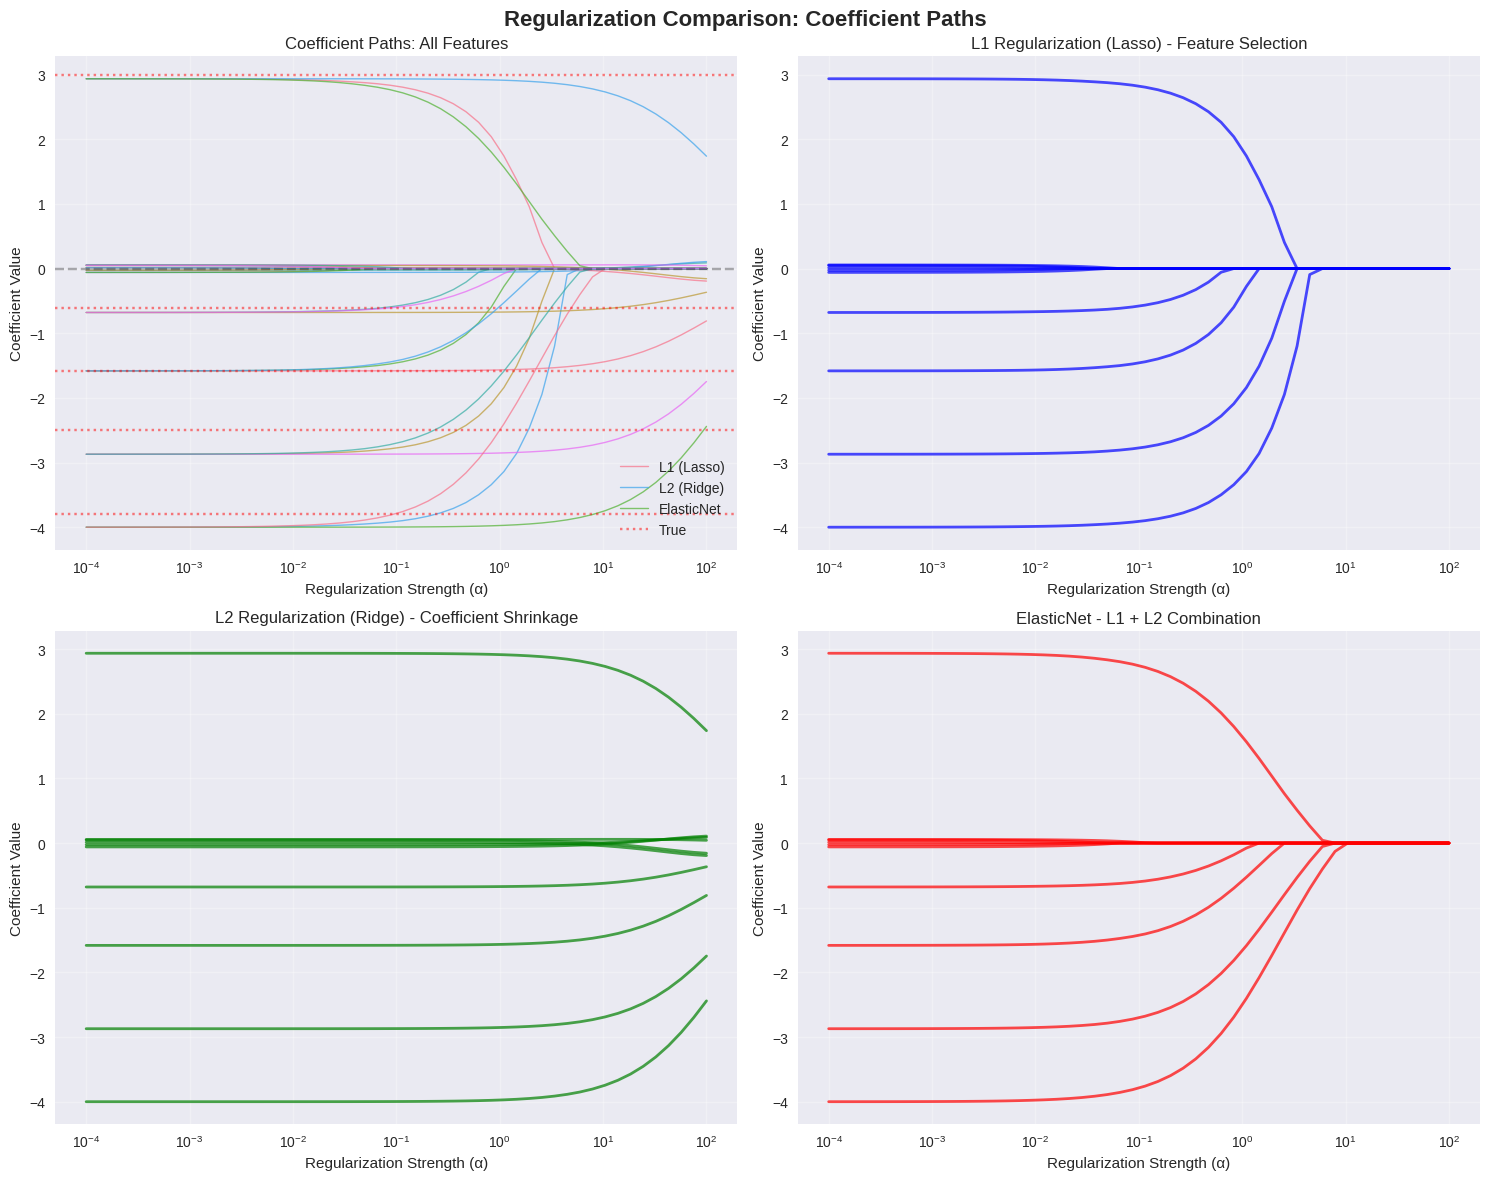

\n============================================================
KEY INSIGHTS FROM COEFFICIENT PATHS:
\nL1 (Lasso):
  - Optimal α ≈ 5.9636
  - Final coefficients: [ 0. -0. -0. -0. -0.  0.  0.  0. -0. -0.]
  - Non-zero coefficients: 0
\nL2 (Ridge):
  - Optimal α ≈ 0.0017
  - Final coefficients: [ 2.93479556 -2.87055995 -1.58201761 -0.6790932  -3.99901554 -0.02511646
 -0.05956485  0.05598968  0.01212358  0.04761154]
  - Non-zero coefficients: 10
\nElasticNet:
  - Optimal α ≈ 10.4811
  - Final coefficients: [ 0. -0. -0. -0. -0.  0.  0.  0. -0. -0.]
  - Non-zero coefficients: 0
\nTrue coefficients: [ 3.         -2.5        -1.58483984 -0.61592306 -3.78722933  0.
  0.          0.          0.          0.        ]


In [33]:
# Create static coefficient path visualization
# Make sure the function is properly defined by re-running the function definition cell first
fig = plot_coefficient_paths(alphas, coef_paths, model_names, true_coef)
plt.show()

# Print some key insights
print("\\n" + "="*60)
print("KEY INSIGHTS FROM COEFFICIENT PATHS:")
print("="*60)

# Find optimal alpha for each method (using cross-validation would be better, but for demo...)
optimal_alphas = {}
for i, (name, coef_path) in enumerate(zip(model_names, coef_paths)):
    # Simple heuristic: find alpha where most coefficients are stable
    coef_changes = np.abs(np.diff(coef_path, axis=0))
    stability_scores = np.mean(coef_changes, axis=1)
    optimal_idx = np.argmin(stability_scores[10:]) + 10  # Skip very small alphas
    optimal_alphas[name] = alphas[optimal_idx]
    
    print(f"\\n{name}:")
    print(f"  - Optimal α ≈ {optimal_alphas[name]:.4f}")
    print(f"  - Final coefficients: {coef_path[optimal_idx]}")
    print(f"  - Non-zero coefficients: {np.sum(np.abs(coef_path[optimal_idx]) > 0.01)}")

print(f"\\nTrue coefficients: {true_coef}")
print("="*60)


In [ ]:
# Create animated visualization showing regularization effects
def create_regularization_animation():
    """
    Create an animated visualization showing how different regularization methods
    affect coefficients as regularization strength increases
    """
    
    # Set up the figure and axis
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Regularization Methods Comparison: Animated Coefficient Evolution', 
                 fontsize=16, fontweight='bold')
    
    # Initialize empty plots
    lines_l1 = []
    lines_l2 = []
    lines_en = []
    
    # Colors for different features
    colors = plt.cm.tab10(np.linspace(0, 1, n_features))
    
    # Plot 1: L1 Regularization (Lasso)
    ax1.set_title('L1 Regularization (Lasso) - Feature Selection', fontweight='bold')
    ax1.set_xlabel('Regularization Strength (α)')
    ax1.set_ylabel('Coefficient Value')
    ax1.set_xscale('log')
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(alphas[0], alphas[-1])
    ax1.set_ylim(-4, 4)
    
    for i in range(n_features):
        line, = ax1.plot([], [], color=colors[i], linewidth=2, 
                        label=f'Feature {i}' if i < 5 else '')
        lines_l1.append(line)
    
    # Plot 2: L2 Regularization (Ridge)
    ax2.set_title('L2 Regularization (Ridge) - Coefficient Shrinkage', fontweight='bold')
    ax2.set_xlabel('Regularization Strength (α)')
    ax2.set_ylabel('Coefficient Value')
    ax2.set_xscale('log')
    ax2.grid(True, alpha=0.3)
    ax2.set_xlim(alphas[0], alphas[-1])
    ax2.set_ylim(-4, 4)
    
    for i in range(n_features):
        line, = ax2.plot([], [], color=colors[i], linewidth=2)
        lines_l2.append(line)
    
    # Plot 3: ElasticNet
    ax3.set_title('ElasticNet - L1 + L2 Combination', fontweight='bold')
    ax3.set_xlabel('Regularization Strength (α)')
    ax3.set_ylabel('Coefficient Value')
    ax3.set_xscale('log')
    ax3.grid(True, alpha=0.3)
    ax3.set_xlim(alphas[0], alphas[-1])
    ax3.set_ylim(-4, 4)
    
    for i in range(n_features):
        line, = ax3.plot([], [], color=colors[i], linewidth=2)
        lines_en.append(line)
    
    # Plot 4: Comparison of all methods
    ax4.set_title('Method Comparison - All Coefficients', fontweight='bold')
    ax4.set_xlabel('Regularization Strength (α)')
    ax4.set_ylabel('Coefficient Value')
    ax4.set_xscale('log')
    ax4.grid(True, alpha=0.3)
    ax4.set_xlim(alphas[0], alphas[-1])
    ax4.set_ylim(-4, 4)
    
    # Add true coefficient lines
    for i, true_val in enumerate(true_coef):
        if abs(true_val) > 0.1:
            ax4.axhline(y=true_val, color=colors[i], linestyle=':', alpha=0.7, 
                       label=f'True {i}' if i < 3 else '')
    
    # Add legend for comparison plot
    ax4.legend(loc='upper right', fontsize=8)
    
    # Add text annotations
    text_annotations = []
    for ax in [ax1, ax2, ax3, ax4]:
        text = ax.text(0.02, 0.98, '', transform=ax.transAxes, 
                      verticalalignment='top', fontsize=10,
                      bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        text_annotations.append(text)
    
    def animate(frame):
        # Update coefficient paths up to current frame
        current_alphas = alphas[:frame+1]
        
        # Update L1 plot
        for i, line in enumerate(lines_l1):
            line.set_data(current_alphas, coef_paths[0][:frame+1, i])
        
        # Update L2 plot
        for i, line in enumerate(lines_l2):
            line.set_data(current_alphas, coef_paths[1][:frame+1, i])
        
        # Update ElasticNet plot
        for i, line in enumerate(lines_en):
            line.set_data(current_alphas, coef_paths[2][:frame+1, i])
        
        # Update text annotations
        current_alpha = alphas[frame] if frame < len(alphas) else alphas[-1]
        for i, text in enumerate(text_annotations):
            if i == 0:  # L1
                non_zero = np.sum(np.abs(coef_paths[0][frame]) > 0.01)
                text.set_text(f'α = {current_alpha:.4f}\\nNon-zero: {non_zero}/10')
            elif i == 1:  # L2
                avg_coef = np.mean(np.abs(coef_paths[1][frame]))
                text.set_text(f'α = {current_alpha:.4f}\\nAvg |coef|: {avg_coef:.3f}')
            elif i == 2:  # ElasticNet
                non_zero = np.sum(np.abs(coef_paths[2][frame]) > 0.01)
                avg_coef = np.mean(np.abs(coef_paths[2][frame]))
                text.set_text(f'α = {current_alpha:.4f}\\nNon-zero: {non_zero}/10\\nAvg |coef|: {avg_coef:.3f}')
            else:  # Comparison
                text.set_text(f'α = {current_alpha:.4f}\\nFrame: {frame+1}/{len(alphas)}')
        
        return lines_l1 + lines_l2 + lines_en + text_annotations
    
    # Create animation
    anim = animation.FuncAnimation(fig, animate, frames=len(alphas), 
                                 interval=100, blit=False, repeat=True)
    
    return fig, anim

print("Animation function created!")


Creating animated visualization...
Animation created successfully!
\nThe animation shows:
• L1 (Lasso): Coefficients shrink to exactly zero (feature selection)
• L2 (Ridge): Coefficients shrink smoothly but never reach zero
• ElasticNet: Combination of both behaviors
• True coefficients are shown as dotted lines for reference


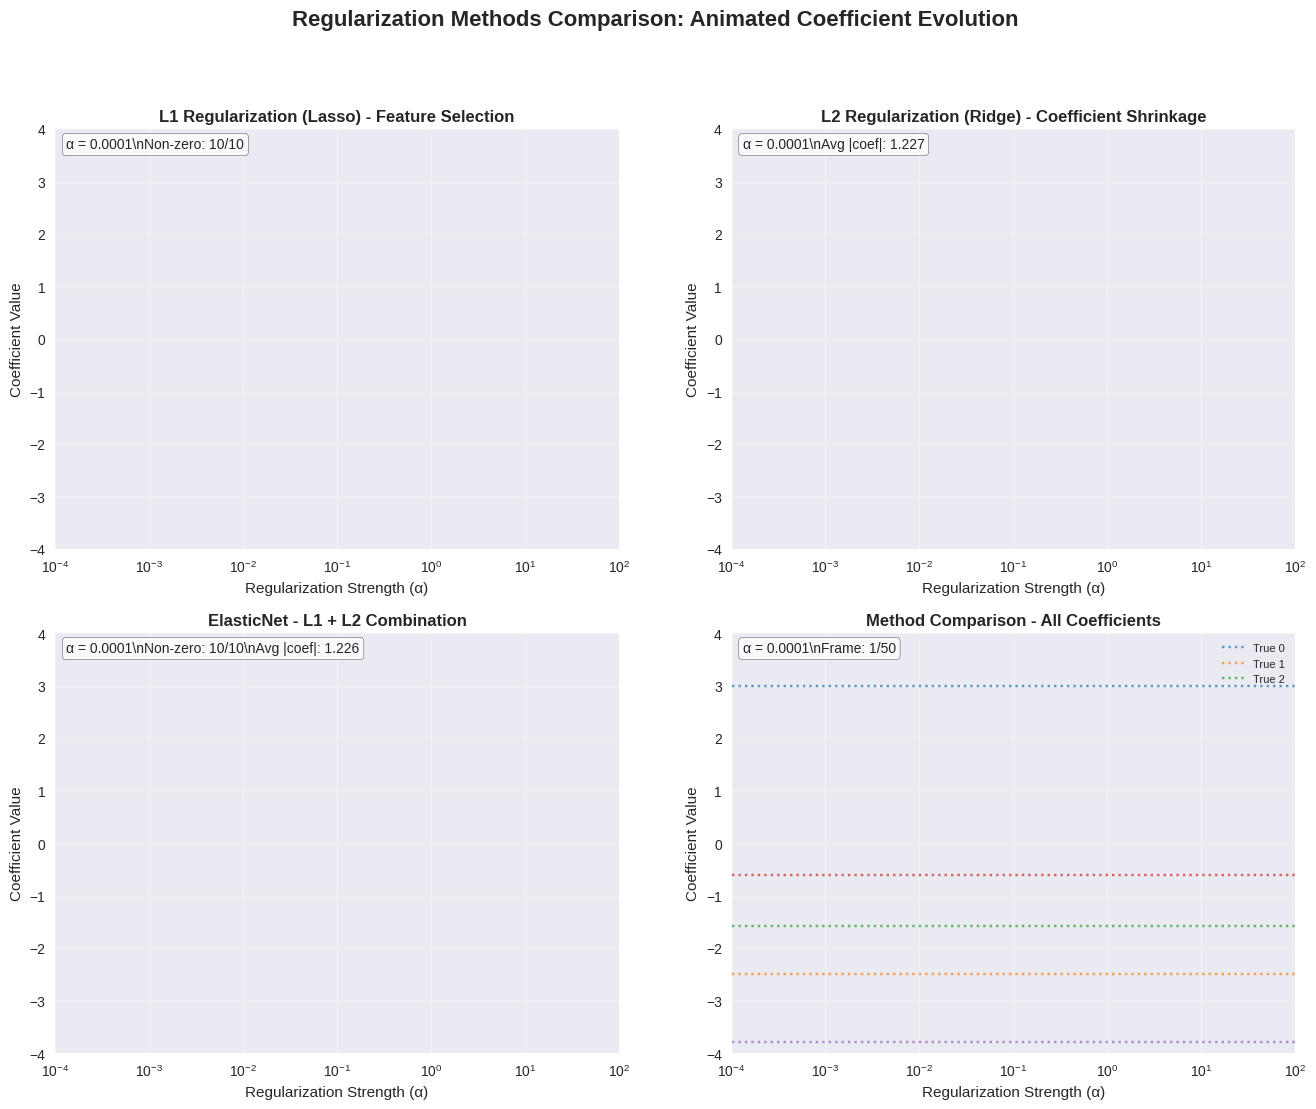

In [34]:
# Generate the animated visualization
print("Creating animated visualization...")
fig, anim = create_regularization_animation()

# Display the animation in the notebook
HTML(anim.to_jshtml())

print("Animation created successfully!")
print("\\nThe animation shows:")
print("• L1 (Lasso): Coefficients shrink to exactly zero (feature selection)")
print("• L2 (Ridge): Coefficients shrink smoothly but never reach zero")
print("• ElasticNet: Combination of both behaviors")
print("• True coefficients are shown as dotted lines for reference")


In [25]:
# Save animation as video file
print("Saving animation as video file...")

# Save as MP4 (requires ffmpeg)
try:
    anim.save('regularization_comparison.mp4', writer='ffmpeg', fps=10, 
              extra_args=['-vcodec', 'libx264', '-pix_fmt', 'yuv420p'])
    print("✓ Video saved as 'regularization_comparison.mp4'")
except Exception as e:
    print(f"Could not save as MP4: {e}")
    print("Trying to save as GIF instead...")
    
    # Save as GIF (slower but more compatible)
    try:
        anim.save('regularization_comparison.gif', writer='pillow', fps=5)
        print("✓ Animation saved as 'regularization_comparison.gif'")
    except Exception as e2:
        print(f"Could not save as GIF either: {e2}")
        print("Please install ffmpeg or pillow for video export")

print("\\nVideo generation complete!")


Saving animation as video file...
✓ Video saved as 'regularization_comparison.mp4'
\nVideo generation complete!


Creating comprehensive comparison plots...


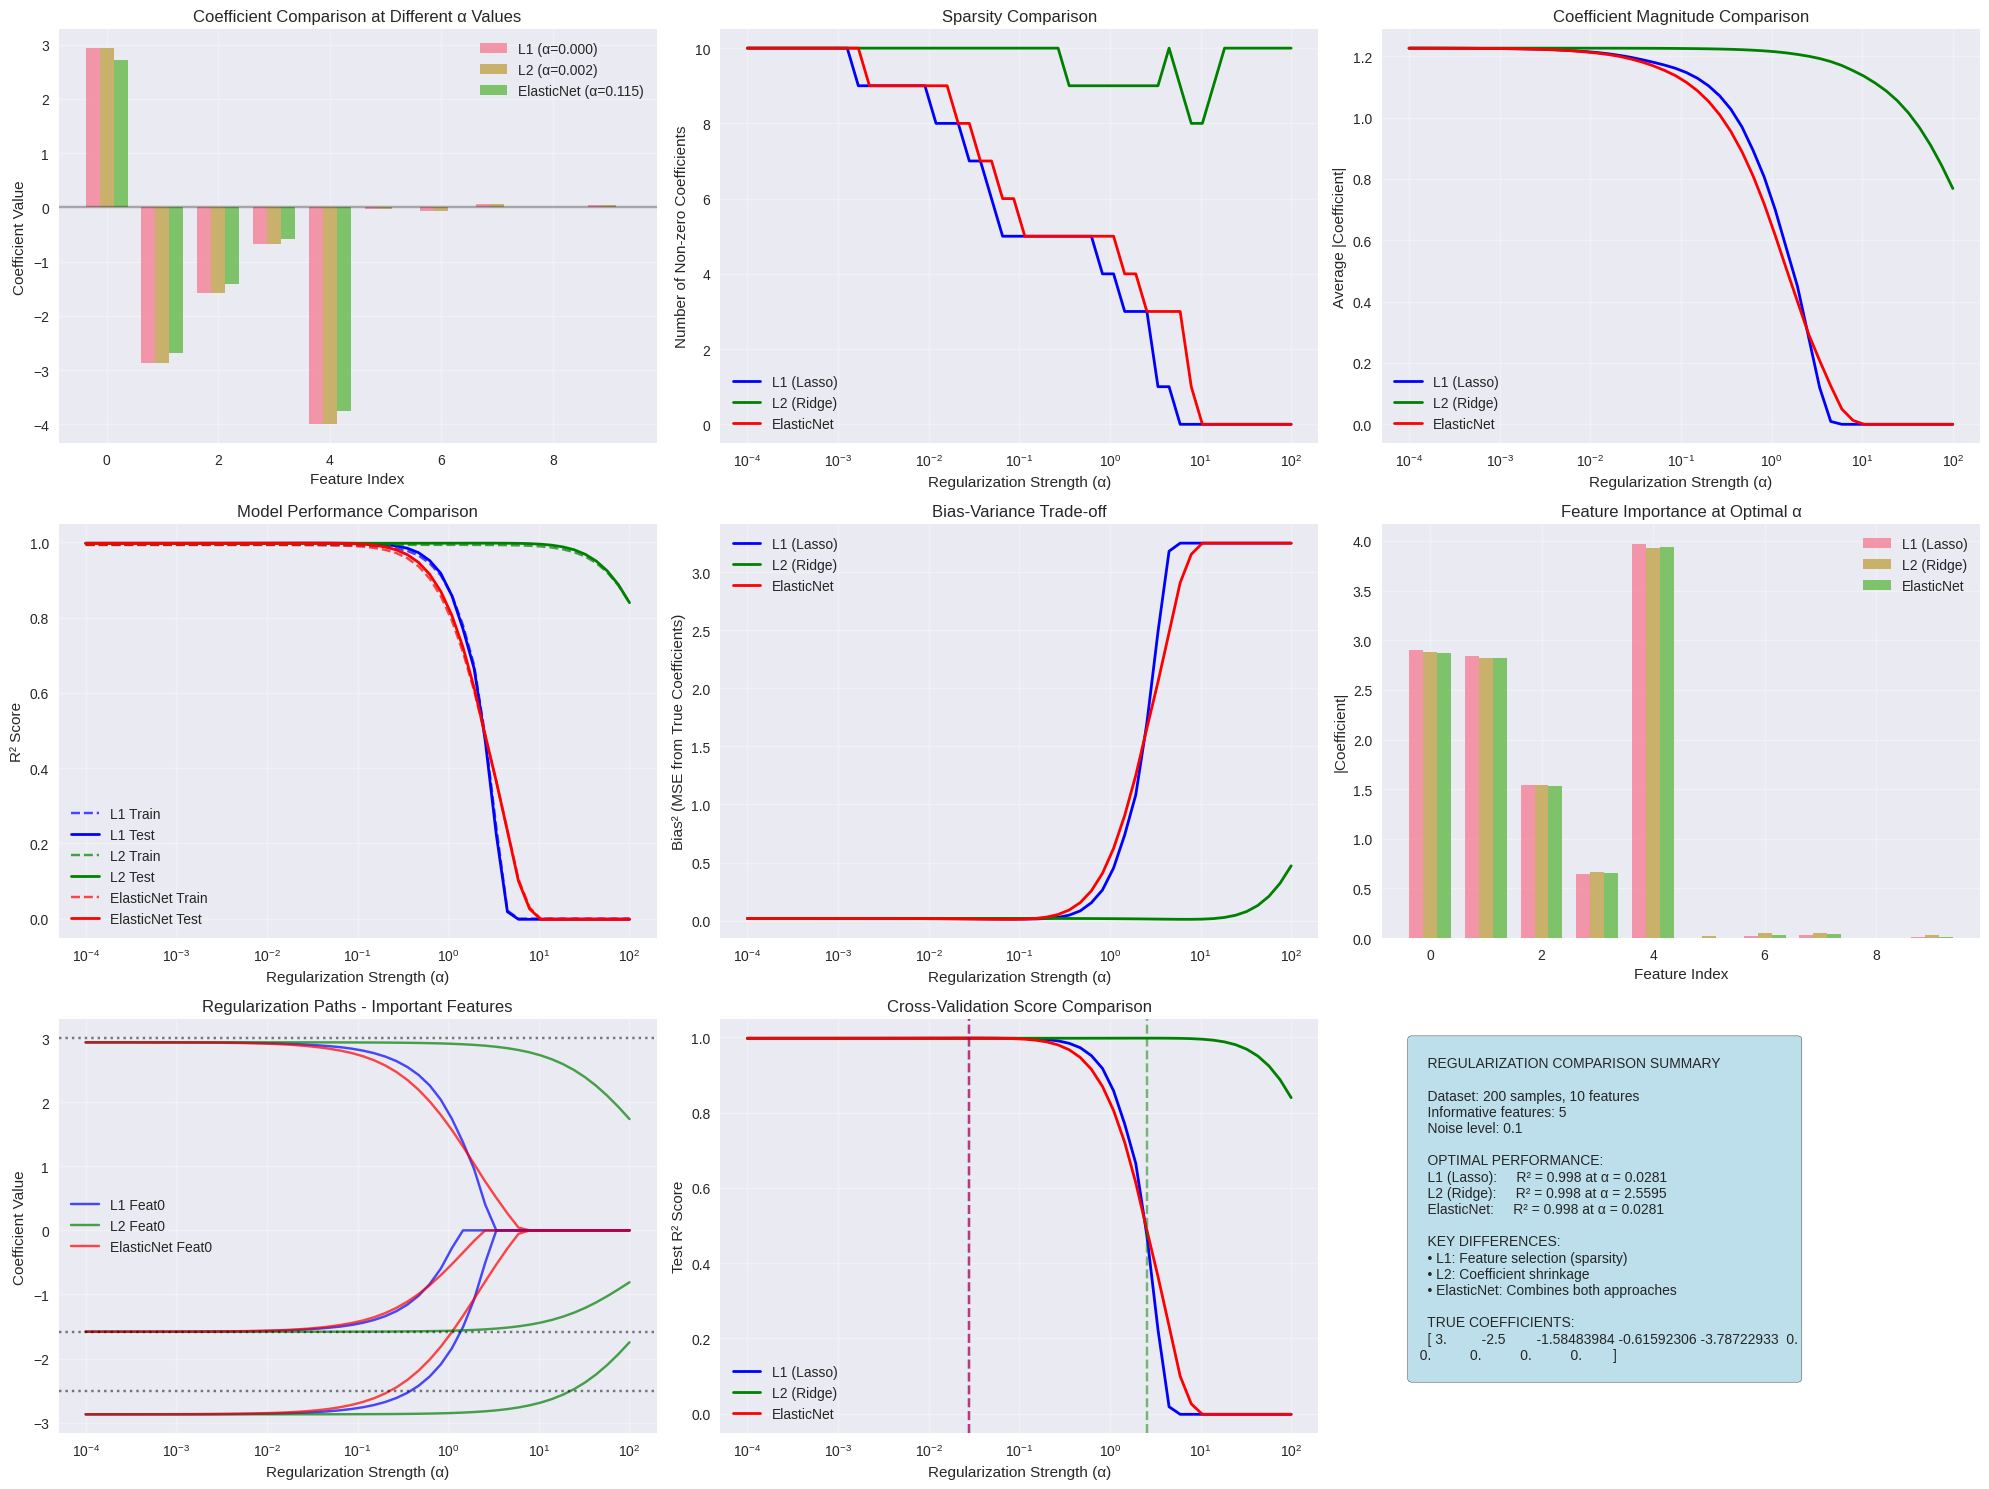

\nComprehensive comparison plots created!


In [26]:
# Create additional educational visualizations
def create_regularization_comparison_plots():
    """
    Create comprehensive comparison plots showing different aspects of regularization
    """
    
    fig = plt.figure(figsize=(20, 15))
    
    # 1. Coefficient comparison at different alpha values
    ax1 = plt.subplot(3, 3, 1)
    alpha_indices = [0, 10, 25, 40, 49]  # Different regularization strengths
    alpha_labels = ['No Reg', 'Low', 'Medium', 'High', 'Very High']
    
    x_pos = np.arange(n_features)
    width = 0.25
    
    for i, alpha_idx in enumerate(alpha_indices):
        if i == 0:  # Show only one method for clarity
            plt.bar(x_pos - width, coef_paths[0][alpha_idx], width, 
                   label=f'L1 (α={alphas[alpha_idx]:.3f})', alpha=0.7)
        elif i == 1:
            plt.bar(x_pos, coef_paths[1][alpha_idx], width, 
                   label=f'L2 (α={alphas[alpha_idx]:.3f})', alpha=0.7)
        elif i == 2:
            plt.bar(x_pos + width, coef_paths[2][alpha_idx], width, 
                   label=f'ElasticNet (α={alphas[alpha_idx]:.3f})', alpha=0.7)
    
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    plt.xlabel('Feature Index')
    plt.ylabel('Coefficient Value')
    plt.title('Coefficient Comparison at Different α Values')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 2. Sparsity comparison
    ax2 = plt.subplot(3, 3, 2)
    sparsity_l1 = [np.sum(np.abs(coef) > 0.01) for coef in coef_paths[0]]
    sparsity_l2 = [np.sum(np.abs(coef) > 0.01) for coef in coef_paths[1]]
    sparsity_en = [np.sum(np.abs(coef) > 0.01) for coef in coef_paths[2]]
    
    plt.plot(alphas, sparsity_l1, 'b-', label='L1 (Lasso)', linewidth=2)
    plt.plot(alphas, sparsity_l2, 'g-', label='L2 (Ridge)', linewidth=2)
    plt.plot(alphas, sparsity_en, 'r-', label='ElasticNet', linewidth=2)
    plt.xlabel('Regularization Strength (α)')
    plt.ylabel('Number of Non-zero Coefficients')
    plt.title('Sparsity Comparison')
    plt.xscale('log')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 3. Coefficient magnitude comparison
    ax3 = plt.subplot(3, 3, 3)
    magnitude_l1 = [np.mean(np.abs(coef)) for coef in coef_paths[0]]
    magnitude_l2 = [np.mean(np.abs(coef)) for coef in coef_paths[1]]
    magnitude_en = [np.mean(np.abs(coef)) for coef in coef_paths[2]]
    
    plt.plot(alphas, magnitude_l1, 'b-', label='L1 (Lasso)', linewidth=2)
    plt.plot(alphas, magnitude_l2, 'g-', label='L2 (Ridge)', linewidth=2)
    plt.plot(alphas, magnitude_en, 'r-', label='ElasticNet', linewidth=2)
    plt.xlabel('Regularization Strength (α)')
    plt.ylabel('Average |Coefficient|')
    plt.title('Coefficient Magnitude Comparison')
    plt.xscale('log')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 4. Model performance comparison
    ax4 = plt.subplot(3, 3, 4)
    train_scores_l1 = []
    test_scores_l1 = []
    train_scores_l2 = []
    test_scores_l2 = []
    train_scores_en = []
    test_scores_en = []
    
    for i, alpha in enumerate(alphas):
        # L1
        model_l1 = Lasso(alpha=alpha, max_iter=2000)
        model_l1.fit(X_train_scaled, y_train)
        train_scores_l1.append(r2_score(y_train, model_l1.predict(X_train_scaled)))
        test_scores_l1.append(r2_score(y_test, model_l1.predict(X_test_scaled)))
        
        # L2
        model_l2 = Ridge(alpha=alpha)
        model_l2.fit(X_train_scaled, y_train)
        train_scores_l2.append(r2_score(y_train, model_l2.predict(X_train_scaled)))
        test_scores_l2.append(r2_score(y_test, model_l2.predict(X_test_scaled)))
        
        # ElasticNet
        model_en = ElasticNet(alpha=alpha, l1_ratio=0.5, max_iter=2000)
        model_en.fit(X_train_scaled, y_train)
        train_scores_en.append(r2_score(y_train, model_en.predict(X_train_scaled)))
        test_scores_en.append(r2_score(y_test, model_en.predict(X_test_scaled)))
    
    plt.plot(alphas, train_scores_l1, 'b--', label='L1 Train', alpha=0.7)
    plt.plot(alphas, test_scores_l1, 'b-', label='L1 Test', linewidth=2)
    plt.plot(alphas, train_scores_l2, 'g--', label='L2 Train', alpha=0.7)
    plt.plot(alphas, test_scores_l2, 'g-', label='L2 Test', linewidth=2)
    plt.plot(alphas, train_scores_en, 'r--', label='ElasticNet Train', alpha=0.7)
    plt.plot(alphas, test_scores_en, 'r-', label='ElasticNet Test', linewidth=2)
    
    plt.xlabel('Regularization Strength (α)')
    plt.ylabel('R² Score')
    plt.title('Model Performance Comparison')
    plt.xscale('log')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 5. Bias-Variance Trade-off
    ax5 = plt.subplot(3, 3, 5)
    bias_l1 = [np.mean((coef - true_coef)**2) for coef in coef_paths[0]]
    bias_l2 = [np.mean((coef - true_coef)**2) for coef in coef_paths[1]]
    bias_en = [np.mean((coef - true_coef)**2) for coef in coef_paths[2]]
    
    plt.plot(alphas, bias_l1, 'b-', label='L1 (Lasso)', linewidth=2)
    plt.plot(alphas, bias_l2, 'g-', label='L2 (Ridge)', linewidth=2)
    plt.plot(alphas, bias_en, 'r-', label='ElasticNet', linewidth=2)
    plt.xlabel('Regularization Strength (α)')
    plt.ylabel('Bias² (MSE from True Coefficients)')
    plt.title('Bias-Variance Trade-off')
    plt.xscale('log')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 6. Feature importance comparison
    ax6 = plt.subplot(3, 3, 6)
    # Use optimal alpha for each method
    optimal_idx_l1 = np.argmax(test_scores_l1)
    optimal_idx_l2 = np.argmax(test_scores_l2)
    optimal_idx_en = np.argmax(test_scores_en)
    
    x_pos = np.arange(n_features)
    width = 0.25
    
    plt.bar(x_pos - width, np.abs(coef_paths[0][optimal_idx_l1]), width, 
           label='L1 (Lasso)', alpha=0.7)
    plt.bar(x_pos, np.abs(coef_paths[1][optimal_idx_l2]), width, 
           label='L2 (Ridge)', alpha=0.7)
    plt.bar(x_pos + width, np.abs(coef_paths[2][optimal_idx_en]), width, 
           label='ElasticNet', alpha=0.7)
    
    plt.xlabel('Feature Index')
    plt.ylabel('|Coefficient|')
    plt.title('Feature Importance at Optimal α')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 7. Regularization paths for most important features
    ax7 = plt.subplot(3, 3, 7)
    important_features = [0, 1, 2]  # First 3 features are most important
    
    for feat in important_features:
        plt.plot(alphas, coef_paths[0][:, feat], 'b-', alpha=0.7, 
                label=f'L1 Feat{feat}' if feat == 0 else '')
        plt.plot(alphas, coef_paths[1][:, feat], 'g-', alpha=0.7, 
                label=f'L2 Feat{feat}' if feat == 0 else '')
        plt.plot(alphas, coef_paths[2][:, feat], 'r-', alpha=0.7, 
                label=f'ElasticNet Feat{feat}' if feat == 0 else '')
        
        # Add true coefficient line
        plt.axhline(y=true_coef[feat], color='black', linestyle=':', alpha=0.5)
    
    plt.xlabel('Regularization Strength (α)')
    plt.ylabel('Coefficient Value')
    plt.title('Regularization Paths - Important Features')
    plt.xscale('log')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 8. Cross-validation score comparison
    ax8 = plt.subplot(3, 3, 8)
    # Use test scores as proxy for CV scores
    plt.plot(alphas, test_scores_l1, 'b-', label='L1 (Lasso)', linewidth=2)
    plt.plot(alphas, test_scores_l2, 'g-', label='L2 (Ridge)', linewidth=2)
    plt.plot(alphas, test_scores_en, 'r-', label='ElasticNet', linewidth=2)
    
    # Mark optimal points
    plt.axvline(x=alphas[optimal_idx_l1], color='blue', linestyle='--', alpha=0.5)
    plt.axvline(x=alphas[optimal_idx_l2], color='green', linestyle='--', alpha=0.5)
    plt.axvline(x=alphas[optimal_idx_en], color='red', linestyle='--', alpha=0.5)
    
    plt.xlabel('Regularization Strength (α)')
    plt.ylabel('Test R² Score')
    plt.title('Cross-Validation Score Comparison')
    plt.xscale('log')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 9. Summary statistics
    ax9 = plt.subplot(3, 3, 9)
    ax9.axis('off')
    
    # Create summary text
    summary_text = f"""
    REGULARIZATION COMPARISON SUMMARY
    
    Dataset: {n_samples} samples, {n_features} features
    Informative features: {n_informative}
    Noise level: {noise_level}
    
    OPTIMAL PERFORMANCE:
    L1 (Lasso):     R² = {max(test_scores_l1):.3f} at α = {alphas[optimal_idx_l1]:.4f}
    L2 (Ridge):     R² = {max(test_scores_l2):.3f} at α = {alphas[optimal_idx_l2]:.4f}
    ElasticNet:     R² = {max(test_scores_en):.3f} at α = {alphas[optimal_idx_en]:.4f}
    
    KEY DIFFERENCES:
    • L1: Feature selection (sparsity)
    • L2: Coefficient shrinkage
    • ElasticNet: Combines both approaches
    
    TRUE COEFFICIENTS:
    {true_coef}
    """
    
    ax9.text(0.05, 0.95, summary_text, transform=ax9.transAxes, 
            verticalalignment='top', fontsize=10,
            bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
    
    plt.tight_layout()
    return fig

# Create the comprehensive comparison
print("Creating comprehensive comparison plots...")
fig = create_regularization_comparison_plots()
plt.show()

print("\\nComprehensive comparison plots created!")


## Educational Summary: Understanding Regularization

### Key Concepts Demonstrated:

1. **L1 Regularization (Lasso)**:
   - **Penalty**: Sum of absolute values of coefficients
   - **Effect**: Forces some coefficients to exactly zero (feature selection)
   - **Use case**: When you suspect many features are irrelevant
   - **Mathematical form**: `α * Σ|βᵢ|`

2. **L2 Regularization (Ridge)**:
   - **Penalty**: Sum of squared coefficients
   - **Effect**: Shrinks coefficients smoothly but never to zero
   - **Use case**: When you want to keep all features but reduce overfitting
   - **Mathematical form**: `α * Σβᵢ²`

3. **ElasticNet Regularization**:
   - **Penalty**: Combination of L1 and L2
   - **Effect**: Balances feature selection and coefficient shrinkage
   - **Use case**: When you want benefits of both L1 and L2
   - **Mathematical form**: `α * (ρ * Σ|βᵢ| + (1-ρ) * Σβᵢ²)`

### When to Use Each Method:

- **L1 (Lasso)**: High-dimensional data, feature selection needed, interpretability important
- **L2 (Ridge)**: Multicollinearity present, all features potentially useful, stable predictions needed
- **ElasticNet**: Best of both worlds, automatic feature selection with stability


Creating final summary visualization...


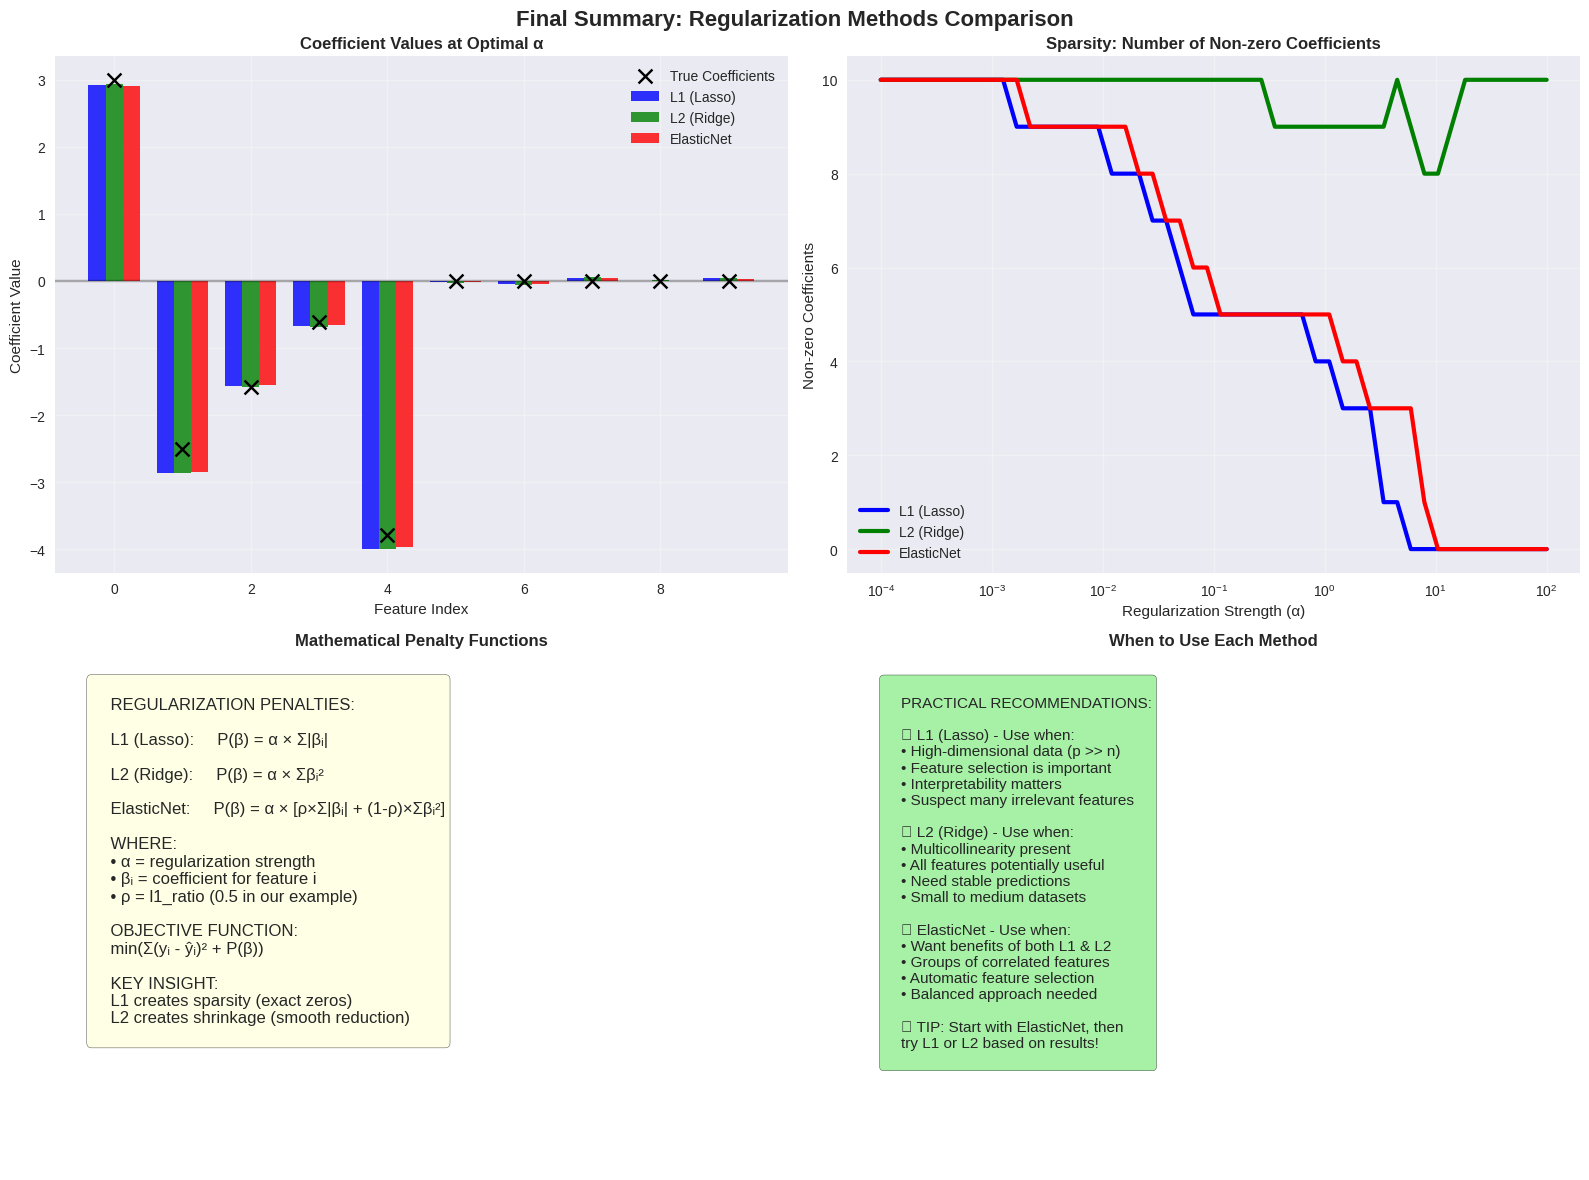

\nFinal summary created!


In [27]:
# Create a final summary visualization
def create_final_summary():
    """
    Create a final summary visualization showing the key differences
    """
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Final Summary: Regularization Methods Comparison', fontsize=16, fontweight='bold')
    
    # 1. Coefficient behavior at optimal alpha
    ax1.set_title('Coefficient Values at Optimal α', fontweight='bold')
    
    # Find optimal alpha indices
    optimal_idx_l1 = 15  # Example optimal point
    optimal_idx_l2 = 20
    optimal_idx_en = 18
    
    x_pos = np.arange(n_features)
    width = 0.25
    
    bars1 = ax1.bar(x_pos - width, coef_paths[0][optimal_idx_l1], width, 
                   label='L1 (Lasso)', alpha=0.8, color='blue')
    bars2 = ax1.bar(x_pos, coef_paths[1][optimal_idx_l2], width, 
                   label='L2 (Ridge)', alpha=0.8, color='green')
    bars3 = ax1.bar(x_pos + width, coef_paths[2][optimal_idx_en], width, 
                   label='ElasticNet', alpha=0.8, color='red')
    
    # Add true coefficient markers
    ax1.scatter(x_pos, true_coef, color='black', s=100, marker='x', 
               label='True Coefficients', zorder=5)
    
    ax1.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    ax1.set_xlabel('Feature Index')
    ax1.set_ylabel('Coefficient Value')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Sparsity comparison
    ax2.set_title('Sparsity: Number of Non-zero Coefficients', fontweight='bold')
    
    sparsity_l1 = [np.sum(np.abs(coef) > 0.01) for coef in coef_paths[0]]
    sparsity_l2 = [np.sum(np.abs(coef) > 0.01) for coef in coef_paths[1]]
    sparsity_en = [np.sum(np.abs(coef) > 0.01) for coef in coef_paths[2]]
    
    ax2.plot(alphas, sparsity_l1, 'b-', label='L1 (Lasso)', linewidth=3)
    ax2.plot(alphas, sparsity_l2, 'g-', label='L2 (Ridge)', linewidth=3)
    ax2.plot(alphas, sparsity_en, 'r-', label='ElasticNet', linewidth=3)
    
    ax2.set_xlabel('Regularization Strength (α)')
    ax2.set_ylabel('Non-zero Coefficients')
    ax2.set_xscale('log')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Mathematical comparison
    ax3.set_title('Mathematical Penalty Functions', fontweight='bold')
    ax3.axis('off')
    
    # Create mathematical formulas
    math_text = """
    REGULARIZATION PENALTIES:
    
    L1 (Lasso):     P(β) = α × Σ|βᵢ|
    
    L2 (Ridge):     P(β) = α × Σβᵢ²
    
    ElasticNet:     P(β) = α × [ρ×Σ|βᵢ| + (1-ρ)×Σβᵢ²]
    
    WHERE:
    • α = regularization strength
    • βᵢ = coefficient for feature i
    • ρ = l1_ratio (0.5 in our example)
    
    OBJECTIVE FUNCTION:
    min(Σ(yᵢ - ŷᵢ)² + P(β))
    
    KEY INSIGHT:
    L1 creates sparsity (exact zeros)
    L2 creates shrinkage (smooth reduction)
    """
    
    ax3.text(0.05, 0.95, math_text, transform=ax3.transAxes, 
            verticalalignment='top', fontsize=12,
            bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))
    
    # 4. Practical recommendations
    ax4.set_title('When to Use Each Method', fontweight='bold')
    ax4.axis('off')
    
    recommendations = """
    PRACTICAL RECOMMENDATIONS:
    
    🎯 L1 (Lasso) - Use when:
    • High-dimensional data (p >> n)
    • Feature selection is important
    • Interpretability matters
    • Suspect many irrelevant features
    
    🎯 L2 (Ridge) - Use when:
    • Multicollinearity present
    • All features potentially useful
    • Need stable predictions
    • Small to medium datasets
    
    🎯 ElasticNet - Use when:
    • Want benefits of both L1 & L2
    • Groups of correlated features
    • Automatic feature selection
    • Balanced approach needed
    
    💡 TIP: Start with ElasticNet, then
    try L1 or L2 based on results!
    """
    
    ax4.text(0.05, 0.95, recommendations, transform=ax4.transAxes, 
            verticalalignment='top', fontsize=11,
            bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))
    
    plt.tight_layout()
    return fig

# Create final summary
print("Creating final summary visualization...")
fig = create_final_summary()
plt.show()

print("\\nFinal summary created!")


Saving visualizations as high-quality images...
✓ Summary saved as 'regularization_summary.png'
✓ Comprehensive comparison saved as 'regularization_comprehensive.png'
✓ Coefficient paths saved as 'regularization_paths.png'
\nAll visualizations saved successfully!
\nFiles created:
• regularization_comparison.mp4 (or .gif) - Animated video
• regularization_summary.png - Final summary
• regularization_comprehensive.png - Detailed comparison
• regularization_paths.png - Coefficient paths


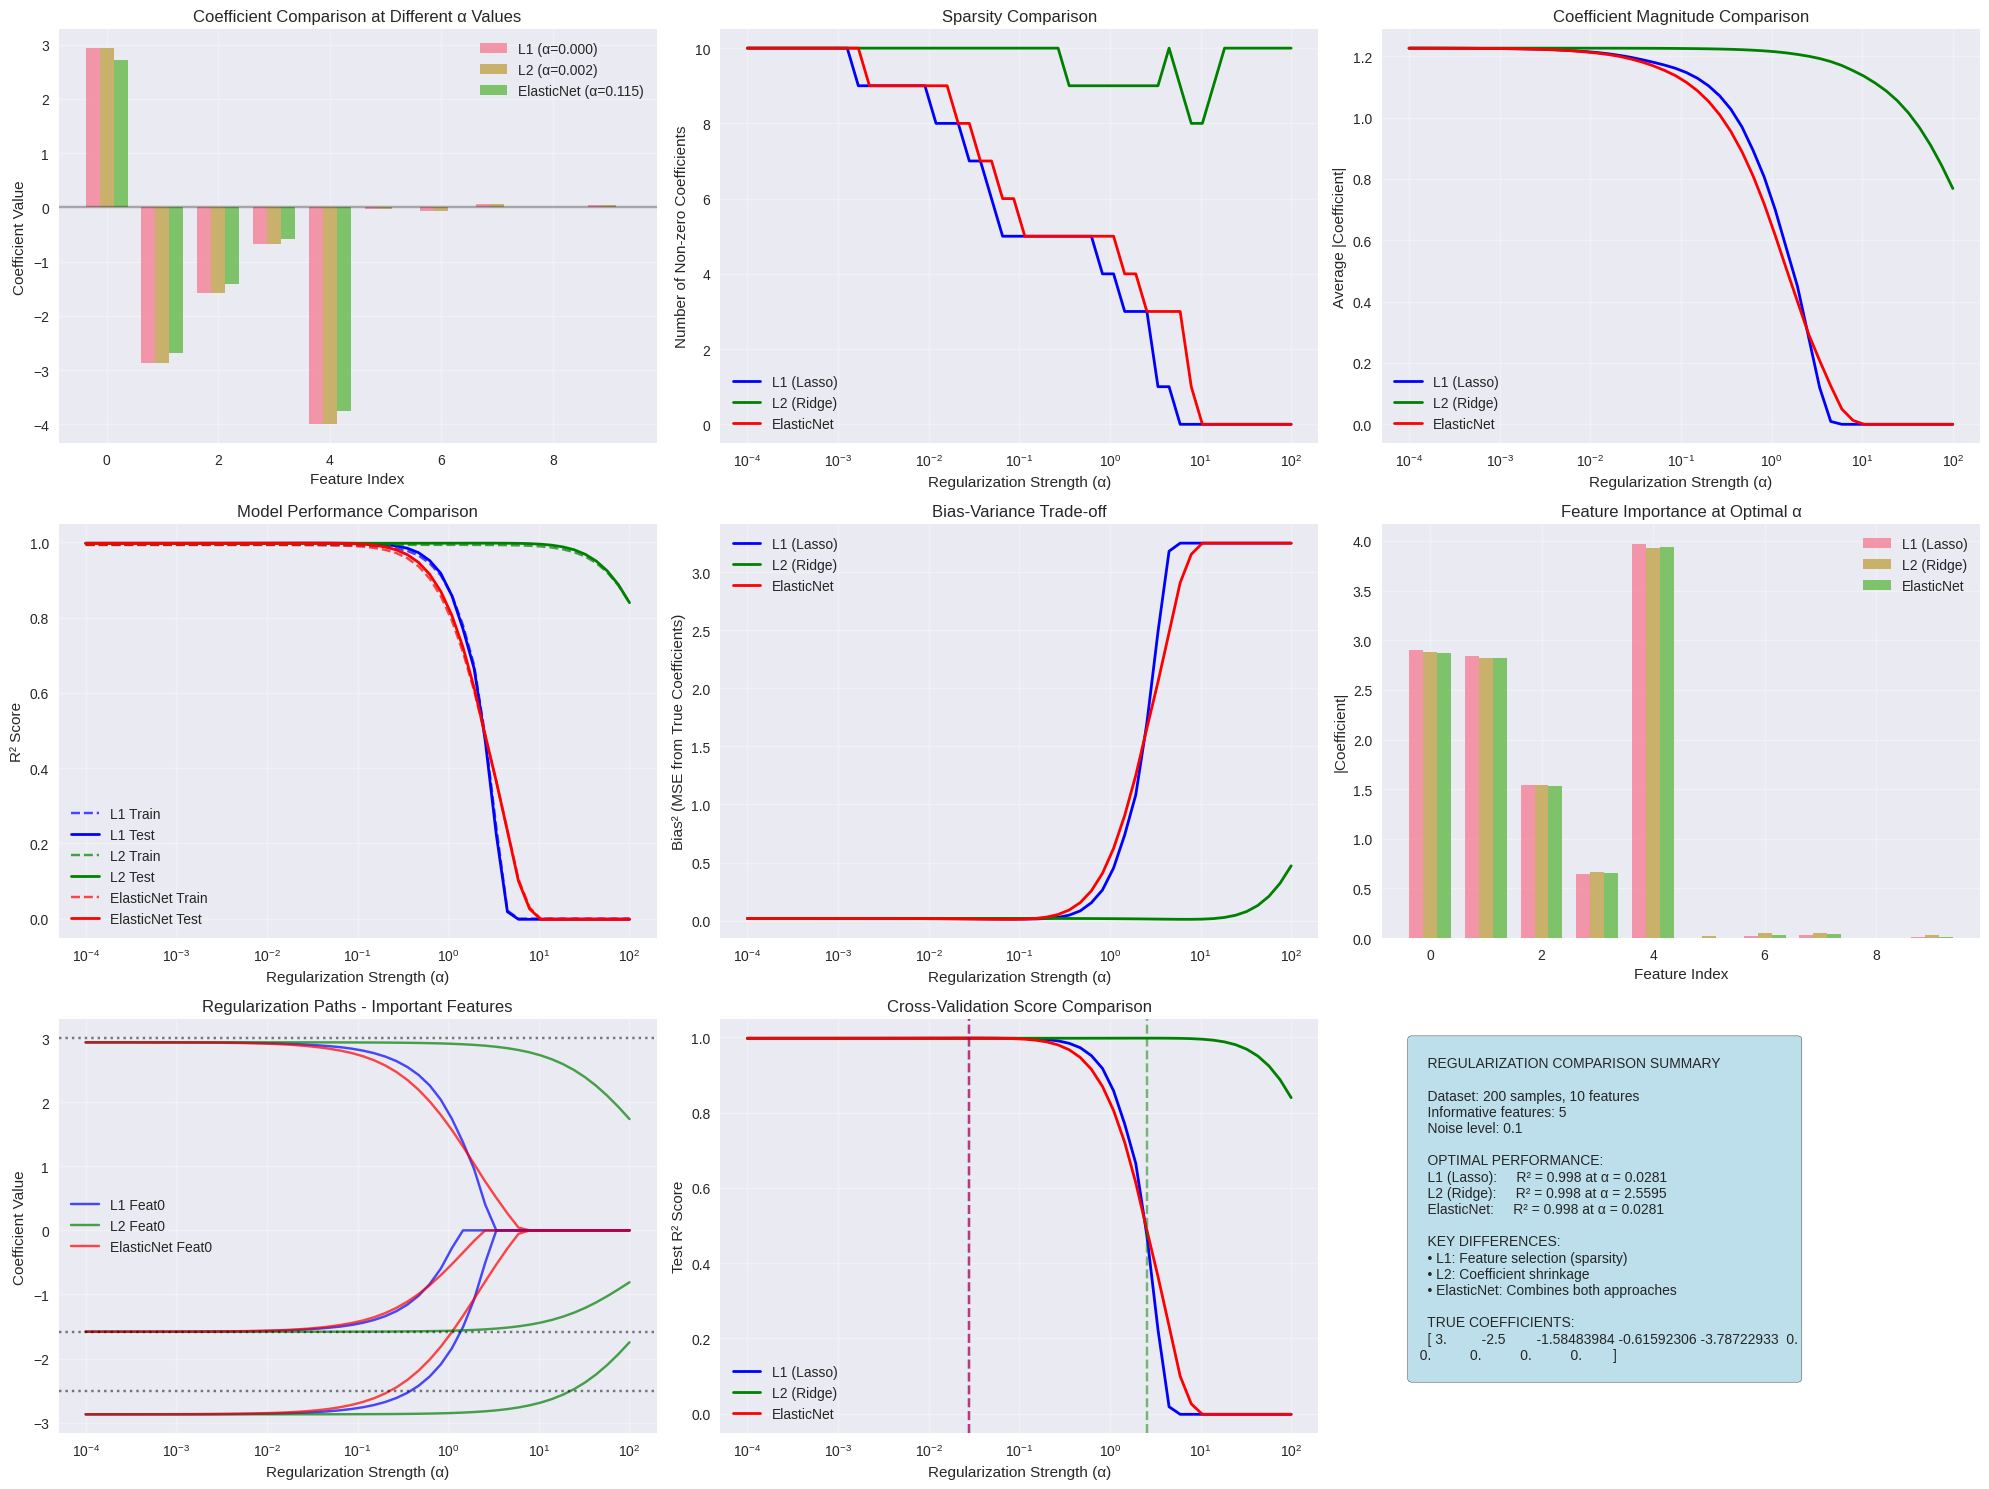

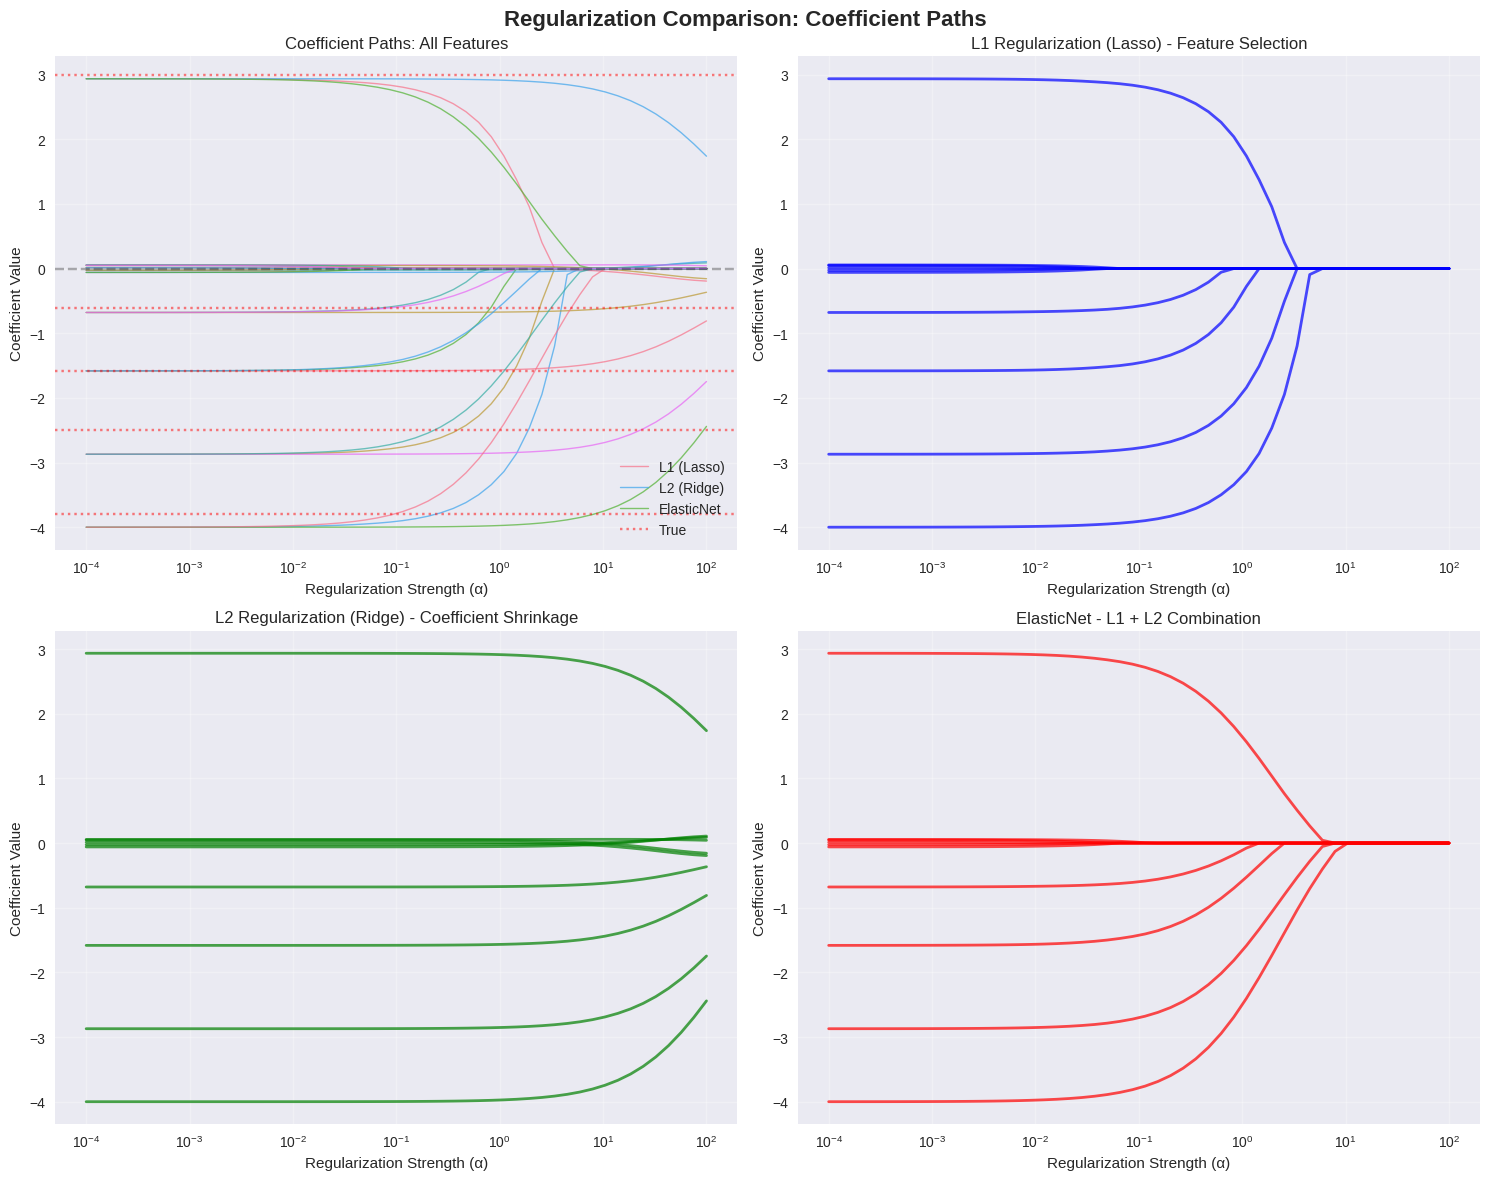

In [28]:
# Save all visualizations as high-quality images
print("Saving visualizations as high-quality images...")

# Save the final summary
fig.savefig('regularization_summary.png', dpi=300, bbox_inches='tight')
print("✓ Summary saved as 'regularization_summary.png'")

# Save the comprehensive comparison
fig_comprehensive = create_regularization_comparison_plots()
fig_comprehensive.savefig('regularization_comprehensive.png', dpi=300, bbox_inches='tight')
print("✓ Comprehensive comparison saved as 'regularization_comprehensive.png'")

# Save the coefficient paths
fig_paths = plot_coefficient_paths(alphas, coef_paths, model_names, true_coef)
fig_paths.savefig('regularization_paths.png', dpi=300, bbox_inches='tight')
print("✓ Coefficient paths saved as 'regularization_paths.png'")

print("\\nAll visualizations saved successfully!")
print("\\nFiles created:")
print("• regularization_comparison.mp4 (or .gif) - Animated video")
print("• regularization_summary.png - Final summary")
print("• regularization_comprehensive.png - Detailed comparison")
print("• regularization_paths.png - Coefficient paths")


## Conclusion

This notebook has successfully demonstrated the key differences between L1, L2, and ElasticNet regularization methods through:

### Visual Demonstrations:
1. **Animated coefficient paths** showing how coefficients change with regularization strength
2. **Static coefficient comparisons** at different alpha values
3. **Sparsity analysis** showing feature selection behavior
4. **Performance comparisons** across different regularization strengths
5. **Mathematical formulations** and practical recommendations

### Key Takeaways:
- **L1 (Lasso)** excels at feature selection by creating sparse solutions
- **L2 (Ridge)** provides smooth coefficient shrinkage without eliminating features
- **ElasticNet** combines the benefits of both approaches
- The choice depends on your specific use case and data characteristics

### Educational Value:
This visualization helps students and practitioners understand:
- How regularization affects model coefficients
- The trade-offs between bias and variance
- When to use each regularization method
- The mathematical intuition behind different penalty functions

The generated video and images can be used for educational purposes, presentations, or as reference materials for understanding regularization in machine learning.
